In [1]:
from sklearn import metrics
from sklearn.model_selection import  train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import *
from keras.preprocessing.image import img_to_array

from keras import layers
from keras import models
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import optimizers
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import Input, MaxPooling2D, Dropout, Flatten
from keras import regularizers
from keras.models import load_model, model_from_yaml
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from datetime import datetime
import csv
import random
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import collections
import os

Using TensorFlow backend.
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\envs\tensor

In [2]:
allpath=[]
def isdirorfile(basepath):
    with os.scandir(basepath) as entries:
        for entry in entries:
            if entry.is_file():
                a = os.path.join(basepath,entry.name)
                if a not in allpath:
                    allpath.append(os.path.join(basepath,entry.name))
            elif entry.is_dir():
                a=os.listdir(basepath)
                if len(a)>=2:
                    tmp=[]                    
                    for i in a:
                        tmp.append(os.path.join(basepath,i))
                    for addr in tmp:
                        isdirorfile(addr)
                else:
                    return isdirorfile(os.path.join(basepath,str(entry.name)))
def datapath(basepath:str):
    dirs = [i for i in os.listdir(basepath)]
    path = [isdirorfile(os.path.join(basepath,x))for x in dirs]
    print(f'總共資料數{len(allpath)}')
    path = allpath
    return path

In [3]:
traindata=datapath(basepath='train')
classes = [i for i in os.listdir('train')]
allpath=[]#初始化宮用餐數
testdata=datapath(basepath='test')
classes={classes[n]:n for n,i in enumerate(classes)}
print(classes)
label=[classes[i.split("\\")[-2]] for i in traindata]
label = np.array(to_categorical(label,10))
test_label=[classes[i.split("\\")[-2]] for i in testdata]
test_label = np.array(to_categorical(test_label,10))

image_path = [os.path.join(os.getcwd(),i) for i in traindata]
test_im_path = [os.path.join(os.getcwd(),i) for i in testdata]

im = [cv2.imread(image_path[i]) for i in tqdm(range(len(image_path)))]
im = [np.array(img_to_array(cv2.resize(image,(32,32),interpolation=cv2.INTER_LINEAR))/255.0) for image in tqdm(im)]

test_im = [cv2.imread(test_im_path[i]) for i in tqdm(range(len(test_im_path)))]
test_im = [np.array(img_to_array(cv2.resize(image,(32,32),interpolation=cv2.INTER_LINEAR))/255.0) for image in tqdm(test_im)]
X,val_X,Y,val_Y = train_test_split(np.array(im),np.array(label),test_size=0.2,random_state=8763)
print(X.shape,val_X.shape,Y.shape,val_Y.shape )

總共資料數50000


  0%|                                                                                                                                                                  | 0/50000 [00:00<?, ?it/s]

總共資料數10000
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 80215.12it/s]


(40000, 32, 32, 3) (10000, 32, 32, 3) (40000, 10) (10000, 10)


In [10]:
def conv2d_bn(x,filters, num_row,num_col,padding='same',strides=(1, 1),name=None):
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=name)(x)
    x = layers.BatchNormalization(axis=3, scale=False)(x)
    x = layers.Activation('relu')(x)
    return x
def get_model(w=32,h=32,ch=3):
    inputs = keras.Input((w, h, ch))
    
    x = conv2d_bn(inputs,32,3,3,strides=(2,2))
    x = MaxPooling2D(pool_size=3,strides=1)(x)
    x = conv2d_bn(x,64,3,3)
    x = MaxPooling2D(pool_size=3,strides=2)(x)
    x = conv2d_bn(x,96,3,3)
    x = MaxPooling2D(pool_size=3,strides=1)(x)
    flatten_layer = Flatten()(x)
    dense_layer_1 = Dense(512,activation='relu')(flatten_layer)
    dense_layer_2 = Dense(256,activation='relu')(dense_layer_1)
    outputs = Dense(10,activation='softmax')(dense_layer_2)
    model = keras.Model(inputs,outputs,name="CIFAR10Net")
    return model

In [11]:
model = get_model(32,32,3)
model.summary()
model.compile(optimizer= keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0) , loss='categorical_crossentropy' , metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', mode = "max",patience=10,restore_best_weights=True)
history = model.fit(
    X,
    y=Y,
    batch_size=32,
    validation_data=(val_X, val_Y),
    epochs=1000,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]
)
print("done!")

Model: "CIFAR10Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        864       
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 32)        96        
_________________________________________________________________
activation_12 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18432     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        1

In [13]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}_loss.jpg'.format("Training and validation loss"), dpi=100)
    #plt.savefig('{}_loss.pdf'.format( EXP_NAME), dpi=300)
    plt.show()
    
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}_acc.jpg'.format("Training and validation"), dpi=100)
    #plt.savefig('{}_acc.pdf'.format(output_path, EXP_NAME), dpi=300)
    plt.show()

(10000, 32, 32, 3)


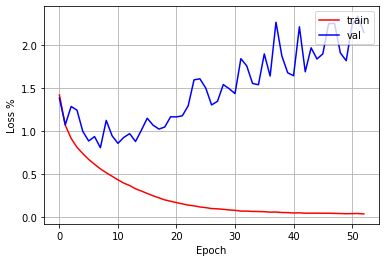

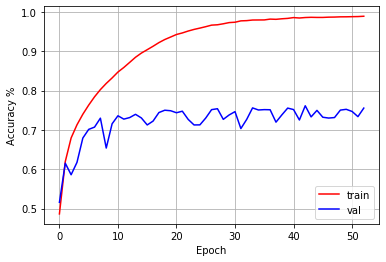

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='mangovgg.png')
y_pred_max = []

y_true = [np.argmax(i)for i in test_label]
print(np.array(test_im).shape)
for valdata in (test_im):
    prediction = model.predict(np.expand_dims(valdata, axis=0))[0]
    y_pred_max.append( np.argmax(prediction))
    
plot_loss_accu(history)

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})
              precision    recall  f1-score   support

    airplane       0.75      0.81      0.78      1000
  automobile       0.84      0.89      0.86      1000
        bird       0.72      0.63      0.67      1000
         cat       0.57      0.59      0.58      1000
        deer       0.70      0.75      0.73      1000
         dog       0.72      0.59      0.65      1000
        frog       0.83      0.79      0.81      1000
       horse       0.73      0.83      0.78      1000
        ship       0.81      0.86      0.84      1000
       truck       0.87      0.78      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



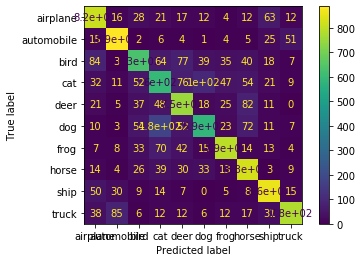

In [16]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import collections
print(collections.Counter(y_true))
confusion_mtx = confusion_matrix(y_true, y_pred_max)
class_names = [i for i in os.listdir('train')]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx,display_labels=class_names)
disp.plot()

print(classification_report(y_true, y_pred_max, target_names=class_names))
